## Coal Production in Mines-2015

by: Jean Njoroge

### Abstract
I used the 2015 Coal production [data](http://www.eia.gov/coal/data.php#production) from the U.S. Energy Information Administration’s (EIA)  as an exercise for regression by random forest.( Note a few differences between classification and regression random forests). 

The EIA uses the data for coal supply analyses and in short-term modeling efforts, which produce forecasts of coal supply and prices requested by Congress. The forecast data also appear in the Short-Term Energy Outlook and the Annual Energy Outlook.

**Implmentation Details**
* Data Source:  http://www.eia.gov/coal/data.php#production
* Data Split: *(70% 30%)*
* Model: *Random Forest Regression*
* Model evalaution: **R^2, Mean Absolute Error, Mean Squared Error, and explained variance score**


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score,mean_absolute_error

sns.set();

## 1.0 Load Data 
We cleaned the data found in the notebook Deliver/Data_cleaning.ipynb

In [25]:
#load the cleaned data and select a few columns to view
df=pd.read_csv('../data/cleaned_coalpublic2015.csv', index_col='MSHA ID')
df[['Year','Mine_Name',"Mine_Status"]].head()

,Year,Mine_Name,Mine_Status
MSHA ID,,,
103381,2015,Jesse Creek H.W.M.,Active
103246,2015,Bear Creek,Temporarily closed
103451,2015,Knight Mine,Temporarily closed
102933,2015,Mine No 2,Temporarily closed
100627,2015,Flat Top Mine,Active


## Predict the production of coal mines in 2015
What caused high or lower production?

### Feature Engineering

Of the above features on two are number: labour hours and Average_employee--Split into numerical features; and categorical variables

In [26]:
features =["Average_Employees",
            "Labor_Hours" ,
              ]

categoricals = ['Mine_State',
               'Mine_County',
               'Mine_Status',
               'Mine_Type',
               "Company_Type",
               "Operation_Type",
               "Union_Code",
               "Coal_Supply_Region",
                      ]
           
target = ['log_production'] 

### What is the relationship between Mine_Status and log_production?

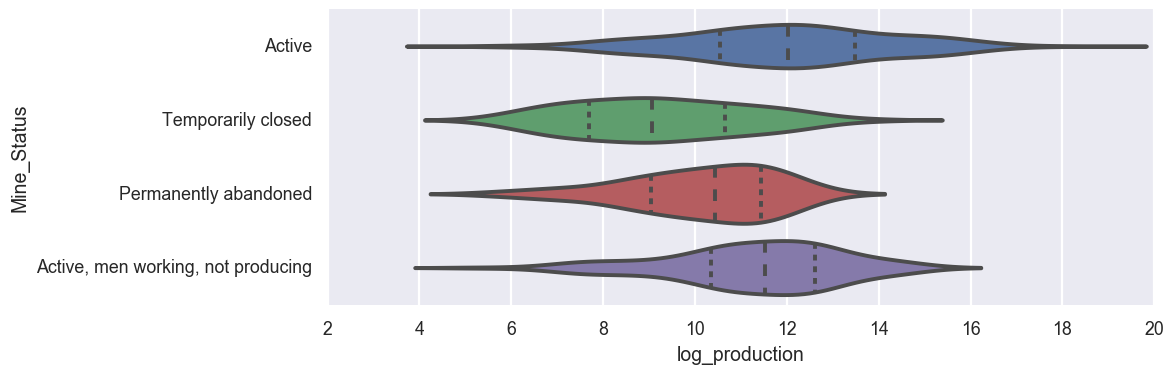

In [27]:
#fig = plt.sublots(figsize = (14,8))
plt.figure(figsize=(12,4))
sns.set_context('poster', font_scale=0.8)
sns.violinplot(y="Mine_Status", x = "log_production", data=df,
              inplace =True, inner ="quartile")
plt.tight_layout()
plt.savefig('../figures/Predicting_coal_Mine_Status_vs_log_production.png')

In [28]:
#convert cetegorical varables into dummy numeric variables
dummy_categoricals = []
for categorical in categoricals:
    print categorical, len(df[categorical].unique())
    # Avoid the dummy trap variable
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    #concanate
    df = pd.concat([df, temp_df],axis =1)
    temp_df.drop("_".join([categorical,str(drop_var)]), axis =1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 151
Mine_Status 4
Mine_Type 3
Company_Type 3
Operation_Type 2
Union_Code 6
Coal_Supply_Region 9


## Model Random Forest Regressor

In [29]:
train, test = train_test_split(df, test_size=0.3, random_state=0)

In [30]:
model = RandomForestRegressor(n_estimators=100, oob_score=True)
model.fit(train[features + dummy_categoricals],train[target])

/Users/shirojean/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

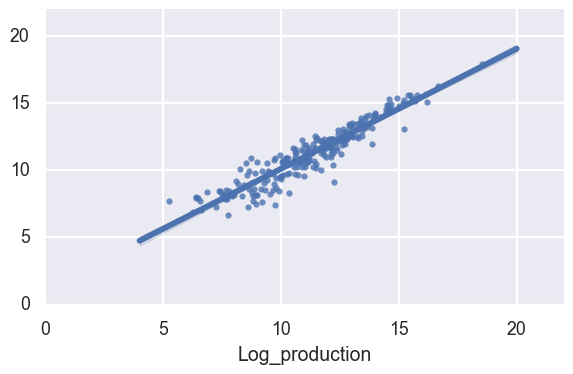

In [31]:
plt.figure(figsize=(6,4))
sns.regplot(test[target], model.predict(test[features + dummy_categoricals]))
plt.xlabel('Log_production')
#plt.ylabel("Predicted Production")
plt.xlim(0,22)
plt.ylim(0,22)
plt.tight_layout()
plt.savefig('../figures/coal-production-RF-predicition.png')

## Model evaluatuion: Regression metrics

The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. Some of those have been enhanced to handle the multioutput case: 
* mean_squared_error, 
* mean_absolute_error, 
* explained_variance_score and 
* r2_score.

In [32]:

predicted = model.predict(test[features + dummy_categoricals])
print 'R^2 Score:', r2_score(test[target],predicted)
print 'Explained Variance Score:',explained_variance_score(test[target], predicted)
print 'Mean Absolute Error(MAE):', mean_absolute_error(test[target], predicted)
print 'Mean Squared Error(MSE):', mean_squared_error(test[target], predicted)

R^2 Score: 0.885542194209
Explained Variance Score: 0.885817911032
Mean Absolute Error(MAE): 0.575557761489
Mean Squared Error(MSE): 0.590905176515


In [33]:
rf_importance =pd.DataFrame({'name':train[features+dummy_categoricals].columns,
                            'importance':model.feature_importances_
                            }).sort_values(by='importance', ascending =False).reset_index(drop=True)
rf_importance.head(5)

,importance,name
0,0.795989,Labor_Hours
1,0.113956,Average_Employees
2,0.011158,Coal_Supply_Region_Powder River Basin
3,0.005674,Mine_Type_Surface
4,0.004523,Mine_Status_Active


## Conclusion
I evaluated the importance of features on an coal production regression task. 
As expected, the labor hours and Employees working on a coal mine show an order of magnitude importance compared to other feature. 


### Reference
1. General paper on Random Forest by regression and Classification: http://www.bios.unc.edu/~dzeng/BIOS740/randomforest.pdf